In [4]:
import requests
import json
import threading
import csv
from datetime import datetime
import time
import re
import matplotlib.pyplot as plt

from pyquery import PyQuery as pq

from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

def log(t):
    ts = datetime.now().strftime('%H:%M:%S')
    print('{} :: {}'.format(ts, t))

In [2]:
SPRING_SUMMER = 'spring-summer'
FALL_WINTER = 'fall-winter'
SEASON_TEMPLATE = 'https://www.supremecommunity.com/season/{}{}/droplists/'

USER_AGENT_1 = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.106 Safari/537.36'
USER_AGENT_2 = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36'
USER_AGENT_3 = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/605.1.15 (KHTML, like Gecko)'
USER_AGENT_4 = 'Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X) AppleWebKit/601.1.46 (KHTML, like Gecko) Mobile/13G36'
USER_AGENT_5 = 'Mozilla/5.0 (iPhone; CPU iPhone OS 13_4_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.1 Mobile/15E148 Safari/604.1'

def cut_last_six(s):
    return s[:-6]

def sc_to_stockx_name(sc):
    sc = sc.replace(' ', '-')
    sc = sc.replace('L/S', 'ls')
    sc = sc.replace('/', '-')
    sc = sc.replace('™', '-')
    sc = sc.replace('®', '-')
    sc = sc.replace('&', '-')
    sc = sc.replace('+', '-')
    sc = sc.replace('"', '')
    sc = sc.replace('--', '-')
    sc = sc.replace('.','')
    sc = sc.replace('Supreme', '')
    sc = 'supreme-' + sc + '-black'
    sc = sc.replace('--', '-')
    return sc

In [3]:
class Downloader(threading.Thread):
    def __init__(self):
        threading.Thread.__init__(self)
        self.S = requests.Session()
        self.S.headers = {
            'user-agent': USER_AGENT_2,
            'content-type': 'application/json'
        }
        self.rawdetails = {}
        
    def get_search_results(self, query):
        log('Retrieving search results for {}'.format(query))
        
        r = self.S.request(
            method='get',
            url='https://stockx.com/api/browse?&_search={}'.format(query),
        )
        try:
            j = r.json()
        except json.decoder.JSONDecodeError:
            log('Product detail retrieval failed [{}]'.format(r.status_code))
            return 'Failed'
        try:
            r.raise_for_status()
        except requests.exceptions.HTTPError:
            log('Product detail retrieval failed [{}] : {}'.format(r.status_code, j['error']))
            return 'Failed'
        return j
    
    def get_raw_details(self, product):
        log('Retrieving raw details for {}'.format(product))
        
        r = self.S.request(
            method='get',
            url='https://stockx.com/api/products/{}?includes=market'.format(product),
            params = {
            }
        )
        try: 
            j = r.json()
        except json.decoder.JSONDecodeError:
            log('Product detail retrieval failed [{}]'.format(r.status_code))
            return 'Failed'
        except requests.exceptions.HTTPError as e:
            log("Error: " + str(e))
            return "Failed"
        try:
            r.raise_for_status()
        except requests.exceptions.HTTPError as e:
#             log('Product detail retrieval failed [{}] : {}'.format(r.status_code, j['error']))
            log("Error: " + str(e))
            return "Failed"
        self.rawdetails = j
        return j

In [80]:
def get_season_links(season, year):
    response = requests.get(SEASON_TEMPLATE.format(season, year))
    doc = pq(response.content)
    links = [('https://www.supremecommunity.com' + pq(block).attr('href'), pq(block).attr('href')[-11:-1])
            for block in doc('a.block')]
    links.reverse()
    return links

def get_week_tees_from_url(url):
    response = requests.get(url)
    doc = pq(response.content)
    return [{'name': pq(card).find('h2').text(), 'retail': pq(card).find('.label-price').text()} 
            for card in doc('.card.card-2') 
            if pq(card).find('.category').text() == 't-shirts']

def get_season_tees(season, year):
    return [{"week": link[1],"tees": get_week_tees_from_url(link[0])}
            for link in get_season_links(season,year)]

def get_all_tees():
    all_tees = []
    for y in [2017, 2018, 2019]:
        for s in [SPRING_SUMMER, FALL_WINTER]:
            all_tees.append(get_season_tees(s,y))
    all_tees.append(get_season_tees(SPRING_SUMMER, 2020))
    return all_tees

def add_stockx_names(lst):
    for season in lst:
        for week in season:
            for t in week['tees']:
                t['search'] = sc_to_stockx_name(t['name'])
    return lst

# TODO: verify urls, then a getter for colors

def ss18(lst):
    for season in lst:
        for week in season:
            for t in week['tees']:
                if week['week'] == '2018-06-28':
                    t['search'] += '-ss18' 
        
def add_stockx_prices(lst):
    d = Downloader()
    for season in lst:
        for week in season:
            for t in week['tees']:
                # 3 seconds is enough to avoid bans
                time.sleep(3)
                search_result = d.get_raw_details(t['search'])
                try:
                    t['price'] = search_result['Product']['market']['averageDeadstockPrice']
                    if t['price'] == 0:
                        t['price'] = "Bad search: zero average"
                    print('Good search. '+ str(t['price']))
                except (AttributeError, IndexError, TypeError, KeyError):
                    print("{} was a bad search".format(t['search']))
                    t['price'] = "Bad search"
    return lst

In [5]:
def csv_to_object(c):
    ob = []
    with open(c, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            ob.append({'name': row['ï»¿name'], 'search': row['stockx search'], 'week': row['release date']})
    return ob

In [6]:
def get_all_search_results(tees):
    d = Downloader()
    for t in tees:
        search = cut_last_six(t['search'])
        j = d.get_search_results(search)['Products']
        all_results.append(j)
        time.sleep(4)
    return all_results

def get_all_info(tees, start, end):
    d = Downloader()
    for t in tees[start:end]:
        search = cut_last_six(t['search']).lower()
        j = d.get_search_results(search)['Products']
        colors = []
        total = 0
        num = 0
        for p in j:
            if search in str(p['urlKey']) and p['childId'] is None:
                colors.append({'color': p['urlKey'].replace(search,'')[1:], 'price': p['market']['averageDeadstockPrice']})
                if p['market']['averageDeadstockPrice']:
                    num += 1
                    total += p['market']['averageDeadstockPrice']
        print('Got {} colors'.format(len(colors)))
        t['colors'] = colors
        if num > 0:
            t['average'] = total/num
        
    with open('data{}-{}.json'.format(start,end), 'w') as outfile:
        json.dump(tees[start:end], outfile)
    return tees[start:end]
    
                

In [23]:
tees = csv_to_object('supreme black tees.csv')

In [8]:
all_results = []

In [108]:
get_all_info(tees, 186, 190)

[]

In [13]:
'ss18' in 'supreme-ss18'[-5:]

True

In [7]:
def read_json(lst, file):
    with open(file) as json_file:
        data = json.load(json_file)
        lst += data
        return lst

In [8]:
full = []

In [11]:
read_json(full, 'data0-184.json')

[{'name': 'Sade Tee',
  'search': 'supreme-Sade-Tee-black',
  'colors': [{'color': 'mocha', 'price': 208},
   {'color': 'black', 'price': 246},
   {'color': 'white', 'price': 212},
   {'color': 'heather-grey', 'price': 172},
   {'color': 'navy', 'price': 191},
   {'color': 'lime-green', 'price': 218},
   {'color': 'lt-pink', 'price': 196},
   {'color': 'aqua', 'price': 189},
   {'color': 'red', 'price': None}],
  'average': 204.0},
 {'name': 'Elephant Tee',
  'search': 'supreme-Elephant-Tee-black',
  'colors': [{'color': 'pink', 'price': 318},
   {'color': 'grey', 'price': 121},
   {'color': 'white', 'price': 233},
   {'color': 'black', 'price': 315},
   {'color': 'lt-green', 'price': 165},
   {'color': 'mocha', 'price': 150},
   {'color': 'aqua', 'price': 180},
   {'color': 'red', 'price': None},
   {'color': 'navy', 'price': None}],
  'average': 211.71428571428572},
 {'name': 'Abstract Tee',
  'search': 'supreme-Abstract-Tee-black',
  'colors': [{'color': 'white', 'price': 107},
   {

In [19]:
len(full)

184

In [127]:
    with open('data0-184.json', 'w') as outfile:
        json.dump(full, outfile)


In [12]:
all_averages = []
black = []
white = []

In [13]:
for p in full:
    try:
        all_averages.append(p['average'])
        for c in p['colors']:
            if c['color'] == 'black':
                black.append(c['price'])
            if c['color'] == 'white':
                white.append(c['price'])
    except (KeyError):
        print(p['name'])

SupremeÂ®/The North FaceÂ® Mountain Tee
SupremeÂ®/The North FaceÂ® Metallic Logo T-Shirt
SupremeÂ®/Comme des GarÃ§ons SHIRTÂ® Split Box Logo Tee
SupremeÂ®/The North FaceÂ® Photo Tee


In [14]:
import matplotlib.pyplot as plt

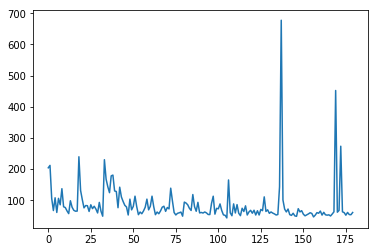

In [15]:
plt.plot(all_averages)

In [145]:
len(all_averages)

306

<Figure size 3600x1440 with 0 Axes>

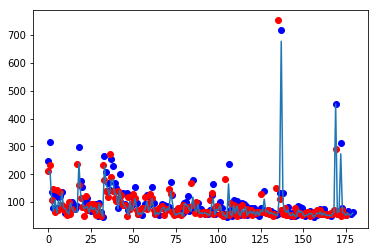

<Figure size 3600x1440 with 0 Axes>

In [21]:
plt.plot(black, 'bo')
plt.plot(white, 'ro')
plt.plot(all_averages)
plt.figure(figsize=(50,20))

In [25]:
len(tees)

184

In [30]:
for i in range(0,184):
    full[i]['date'] = tees[i]['week']
    

In [31]:
full

[{'name': 'Sade Tee',
  'search': 'supreme-Sade-Tee-black',
  'colors': [{'color': 'mocha', 'price': 208},
   {'color': 'black', 'price': 246},
   {'color': 'white', 'price': 212},
   {'color': 'heather-grey', 'price': 172},
   {'color': 'navy', 'price': 191},
   {'color': 'lime-green', 'price': 218},
   {'color': 'lt-pink', 'price': 196},
   {'color': 'aqua', 'price': 189},
   {'color': 'red', 'price': None}],
  'average': 204.0,
  'date': '2/16/2017'},
 {'name': 'Elephant Tee',
  'search': 'supreme-Elephant-Tee-black',
  'colors': [{'color': 'pink', 'price': 318},
   {'color': 'grey', 'price': 121},
   {'color': 'white', 'price': 233},
   {'color': 'black', 'price': 315},
   {'color': 'lt-green', 'price': 165},
   {'color': 'mocha', 'price': 150},
   {'color': 'aqua', 'price': 180},
   {'color': 'red', 'price': None},
   {'color': 'navy', 'price': None}],
  'average': 211.71428571428572,
  'date': '2/16/2017'},
 {'name': 'Abstract Tee',
  'search': 'supreme-Abstract-Tee-black',
  'co

In [34]:
import datetime
d = ['09/01/2012', '04/05/2007', '11/18/2012']
sorted(d, key=lambda x: datetime.datetime.strptime(x, '%m/%d/%Y'))

['04/05/2007', '09/01/2012', '11/18/2012']

In [36]:
# Sort data
sorted(full, key=lambda x: datetime.datetime.strptime(x['date'], '%m/%d/%Y'))

[{'name': 'Sade Tee',
  'search': 'supreme-Sade-Tee-black',
  'colors': [{'color': 'mocha', 'price': 208},
   {'color': 'black', 'price': 246},
   {'color': 'white', 'price': 212},
   {'color': 'heather-grey', 'price': 172},
   {'color': 'navy', 'price': 191},
   {'color': 'lime-green', 'price': 218},
   {'color': 'lt-pink', 'price': 196},
   {'color': 'aqua', 'price': 189},
   {'color': 'red', 'price': None}],
  'average': 204.0,
  'date': '2/16/2017'},
 {'name': 'Elephant Tee',
  'search': 'supreme-Elephant-Tee-black',
  'colors': [{'color': 'pink', 'price': 318},
   {'color': 'grey', 'price': 121},
   {'color': 'white', 'price': 233},
   {'color': 'black', 'price': 315},
   {'color': 'lt-green', 'price': 165},
   {'color': 'mocha', 'price': 150},
   {'color': 'aqua', 'price': 180},
   {'color': 'red', 'price': None},
   {'color': 'navy', 'price': None}],
  'average': 211.71428571428572,
  'date': '2/16/2017'},
 {'name': 'Abstract Tee',
  'search': 'supreme-Abstract-Tee-black',
  'co

In [37]:
# Write
with open('data0-184sorted.json', 'w') as outfile:
    json.dump(full, outfile)

In [38]:
full2 = []

In [39]:
read_json(full2, "data0-184sorted.json")

[{'name': 'Sade Tee',
  'search': 'supreme-Sade-Tee-black',
  'colors': [{'color': 'mocha', 'price': 208},
   {'color': 'black', 'price': 246},
   {'color': 'white', 'price': 212},
   {'color': 'heather-grey', 'price': 172},
   {'color': 'navy', 'price': 191},
   {'color': 'lime-green', 'price': 218},
   {'color': 'lt-pink', 'price': 196},
   {'color': 'aqua', 'price': 189},
   {'color': 'red', 'price': None}],
  'average': 204.0,
  'date': '2/16/2017'},
 {'name': 'Elephant Tee',
  'search': 'supreme-Elephant-Tee-black',
  'colors': [{'color': 'pink', 'price': 318},
   {'color': 'grey', 'price': 121},
   {'color': 'white', 'price': 233},
   {'color': 'black', 'price': 315},
   {'color': 'lt-green', 'price': 165},
   {'color': 'mocha', 'price': 150},
   {'color': 'aqua', 'price': 180},
   {'color': 'red', 'price': None},
   {'color': 'navy', 'price': None}],
  'average': 211.71428571428572,
  'date': '2/16/2017'},
 {'name': 'Abstract Tee',
  'search': 'supreme-Abstract-Tee-black',
  'co

In [41]:
len(full2)

187

In [55]:
ss18tees = csv_to_object('ss18.csv')

In [56]:
get_all_info(ss18tees, 0, 7)

18:04:42 :: Retrieving search results for supreme-rocks-tee
Got 8 colors
18:04:44 :: Retrieving search results for supreme-mona-lisa-tee
Got 8 colors
18:04:44 :: Retrieving search results for supreme-tentacles-tee
Got 8 colors
18:04:45 :: Retrieving search results for supreme-swimmers-tee
Got 7 colors
18:04:45 :: Retrieving search results for supreme-ganesha-tee
Got 7 colors
18:04:45 :: Retrieving search results for supreme-hardware-tee
Got 8 colors
18:04:46 :: Retrieving search results for supreme-gonz-logo-tee
Got 8 colors


[{'name': 'Rocks Tee',
  'search': 'supreme-Rocks-Tee-black',
  'week': '6/28/2018',
  'colors': [{'color': 'white-ss18', 'price': 159},
   {'color': 'black-ss18', 'price': 159},
   {'color': 'red-ss18', 'price': 98},
   {'color': 'ash-grey-ss18', 'price': 88},
   {'color': 'light-purple-ss18', 'price': 92},
   {'color': 'dark-slate-ss18', 'price': 101},
   {'color': 'light-pink-ss18', 'price': 118},
   {'color': 'orange-ss18', 'price': 96}],
  'average': 113.875},
 {'name': 'Mona Lisa Tee',
  'search': 'supreme-Mona-Lisa-Tee-black',
  'week': '6/28/2018',
  'colors': [{'color': 'black-ss18', 'price': 174},
   {'color': 'white-ss18', 'price': 129},
   {'color': 'hot-pink-ss18', 'price': 91},
   {'color': 'pale-yellow-ss18', 'price': 98},
   {'color': 'heather-grey-ss18', 'price': 91},
   {'color': 'red-ss18', 'price': 123},
   {'color': 'royal-ss18', 'price': 119},
   {'color': 'light-purple-ss18', 'price': 69}],
  'average': 111.75},
 {'name': 'Tentacles Tee',
  'search': 'supreme-Ten

In [8]:
complete = []
read_json(complete, 'complete_data.json')

[{'name': 'Sade Tee',
  'search': 'supreme-Sade-Tee-black',
  'colors': [{'color': 'mocha', 'price': 208, 'deadstockSold': 5},
   {'color': 'black', 'price': 246, 'deadstockSold': 35},
   {'color': 'white', 'price': 212, 'deadstockSold': 19},
   {'color': 'heather-grey', 'price': 172, 'deadstockSold': 16},
   {'color': 'navy', 'price': 191, 'deadstockSold': 9},
   {'color': 'lime-green', 'price': 218, 'deadstockSold': 6},
   {'color': 'lt-pink', 'price': 196, 'deadstockSold': 4},
   {'color': 'aqua', 'price': 189, 'deadstockSold': 4},
   {'color': 'red', 'price': None, 'deadstockSold': 0}],
  'average': 204.0,
  'date': '2/16/2017',
  'retail': '44'},
 {'name': 'Elephant Tee',
  'search': 'supreme-Elephant-Tee-black',
  'colors': [{'color': 'pink', 'price': 318, 'deadstockSold': 4},
   {'color': 'grey', 'price': 121, 'deadstockSold': 3},
   {'color': 'white', 'price': 233, 'deadstockSold': 2},
   {'color': 'black', 'price': 315, 'deadstockSold': 1},
   {'color': 'lt-green', 'price': 16

In [65]:
len(complete)

194

In [62]:
colorset = set()
for c in complete_data:
    for color in c['colors']:
        colorset.add(color['color'])

In [64]:
def list_with_color(lst, colors):
    colorlist = []
    for entry in lst:
        for c in entry['colors']:
            if c['color'] in colors and c['color']:
                colorlist.append(entry)
    return colorlist

def find_most_popular_colors(lst, cset):
    popular = []
    for color in cset:
        popular.append({'amount': len(list_with_color(lst, color)), 'name': color})
    popular = sorted(popular, key=lambda x: x['amount'])[:-1]
    popular.reverse()
    return popular

In [113]:
len(list_with_color(complete, {'white'}))

187

In [82]:
colorset

{'acid-yellow',
 'aqua',
 'ash-grey',
 'black',
 'blue',
 'brick',
 'bright-blue',
 'bright-coral',
 'bright-orange',
 'bright-yellow',
 'brown',
 'burgundy',
 'burnt-orange',
 'cardinal',
 'clay',
 'cyan',
 'dark-green',
 'dark-pink',
 'dark-sage',
 'dark-slate',
 'dusty-pink',
 'dusty-teal',
 'green',
 'grey',
 'heather-grey',
 'heather-light-pink',
 'hot-pink',
 'light-blue',
 'light-brown',
 'light-green',
 'light-pink',
 'light-purple',
 'light-slate',
 'lime',
 'lime-green',
 'lt-green',
 'lt-pink',
 'lt-teal',
 'magenta',
 'mint',
 'mocha',
 'mustard',
 'natural',
 'navy',
 'neon-green',
 'neon-orange',
 'olive',
 'olive-green',
 'orange',
 'pale-blue',
 'pale-mint',
 'pale-pink',
 'pale-yellow',
 'peach',
 'pink',
 'purple',
 'red',
 'royal',
 'rust',
 'slate',
 'sulfer',
 'sulfur',
 'taupe',
 'teal',
 'warm-grey',
 'white',
 'woodland-camo',
 'yellow'}

In [107]:
most_popular_colors = find_most_popular_colors(complete, colorset)

colorset

In [120]:
complete

[{'name': 'Sade Tee',
  'search': 'supreme-Sade-Tee-black',
  'colors': [{'color': 'mocha', 'price': 208},
   {'color': 'black', 'price': 246},
   {'color': 'white', 'price': 212},
   {'color': 'heather-grey', 'price': 172},
   {'color': 'navy', 'price': 191},
   {'color': 'lime-green', 'price': 218},
   {'color': 'lt-pink', 'price': 196},
   {'color': 'aqua', 'price': 189},
   {'color': 'red', 'price': None}],
  'average': 204.0,
  'date': '2/16/2017'},
 {'name': 'Elephant Tee',
  'search': 'supreme-Elephant-Tee-black',
  'colors': [{'color': 'pink', 'price': 318},
   {'color': 'grey', 'price': 121},
   {'color': 'white', 'price': 233},
   {'color': 'black', 'price': 315},
   {'color': 'lt-green', 'price': 165},
   {'color': 'mocha', 'price': 150},
   {'color': 'aqua', 'price': 180},
   {'color': 'red', 'price': None},
   {'color': 'navy', 'price': None}],
  'average': 211.71428571428572,
  'date': '2/16/2017'},
 {'name': 'Abstract Tee',
  'search': 'supreme-Abstract-Tee-black',
  'co

In [116]:
black = list_with_color(complete, 'black')
red = list_with_color(complete, 'red')
navy = list_with_color(complete, 'navy')
heatherGrey = list_with_color(complete, 'heather-grey')
white = list_with_color(complete, 'white')

In [81]:
supreme_com = get_all_tees()

In [82]:
supreme_com

[[{'week': '2017-02-16',
   'tees': [{'name': 'Sade Tee', 'retail': '$44/£42'},
    {'name': 'Elephant Tee', 'retail': '$32/£36'},
    {'name': 'Abstract Tee', 'retail': '$32/£35'},
    {'name': 'Eternal Tee', 'retail': '$32/£35'},
    {'name': 'FTP Tee', 'retail': '$32/£35'},
    {'name': 'Automatic Tee', 'retail': '$32/£35'},
    {'name': 'Joe Roberts Swirl Tee', 'retail': '$32/£36'},
    {'name': 'Dream Tee', 'retail': '$44/£40'},
    {'name': 'Been Hit L/S Tee', 'retail': '$44/£40'},
    {'name': 'Larry Clark Girl Tee', 'retail': '$44/£36'}]},
  {'week': '2017-03-02', 'tees': []},
  {'week': '2017-03-09', 'tees': []},
  {'week': '2017-03-16', 'tees': []},
  {'week': '2017-03-23', 'tees': []},
  {'week': '2017-03-30', 'tees': []},
  {'week': '2017-04-06', 'tees': []},
  {'week': '2017-04-13', 'tees': []},
  {'week': '2017-04-20', 'tees': []},
  {'week': '2017-04-27', 'tees': []},
  {'week': '2017-05-04', 'tees': []},
  {'week': '2017-05-11', 'tees': []},
  {'week': '2017-05-18', 'te

In [139]:
print(re.search('\$(.*)/', '$36/$38').group(1))

36


In [131]:
s = 'asdf=5/iwantthis123jasd'
result = re.search('asdf=5/(.*)123jasd', s)
print(result.group(1))

iwantthis


In [88]:
flattened

[{'name': 'Sade Tee', 'retail': '44'},
 {'name': 'Elephant Tee', 'retail': '32'},
 {'name': 'Abstract Tee', 'retail': '32'},
 {'name': 'Eternal Tee', 'retail': '32'},
 {'name': 'FTP Tee', 'retail': '32'},
 {'name': 'Automatic Tee', 'retail': '32'},
 {'name': 'Joe Roberts Swirl Tee', 'retail': '32'},
 {'name': 'Dream Tee', 'retail': '44'},
 {'name': 'Been Hit L/S Tee', 'retail': '44'},
 {'name': 'Larry Clark Girl Tee', 'retail': '44'},
 {'name': 'Mirage Tee', 'retail': '44'},
 {'name': 'Digi Tee', 'retail': '44'},
 {'name': 'Punany Train Tee', 'retail': '48'},
 {'name': 'Super Supreme Tee', 'retail': '48'},
 {'name': 'Undercover Lover Tee', 'retail': '48'},
 {'name': 'Orgy Tee', 'retail': '44'},
 {'name': 'Go Fuck Yourself Tee', 'retail': '46'},
 {'name': 'Buy Off The Bar Tee', 'retail': '48'},
 {'name': 'Know Your Rights Tee', 'retail': '44'},
 {'name': 'Nas Tee', 'retail': '44'},
 {'name': 'Crash Tee', 'retail': '34'},
 {'name': 'Dollar Tee', 'retail': '34'},
 {'name': 'DNA Tee', 'ret

In [83]:
flattened = [item['tees'] for items in supreme_com for item in items]

In [84]:
flattened = [item for items in flattened for item in items]

In [85]:
flattened_keys = {item['name'] for item in flattened}

In [89]:
for f in flattened:
    try:
        f['retail'] = re.search('\$(.*)/',f['retail']).group(1)
    except(AttributeError):
        print(f)

{'name': 'Sade Tee', 'retail': '44'}
{'name': 'Elephant Tee', 'retail': '32'}
{'name': 'Abstract Tee', 'retail': '32'}
{'name': 'Eternal Tee', 'retail': '32'}
{'name': 'FTP Tee', 'retail': '32'}
{'name': 'Automatic Tee', 'retail': '32'}
{'name': 'Joe Roberts Swirl Tee', 'retail': '32'}
{'name': 'Dream Tee', 'retail': '44'}
{'name': 'Been Hit L/S Tee', 'retail': '44'}
{'name': 'Larry Clark Girl Tee', 'retail': '44'}
{'name': 'Mirage Tee', 'retail': '44'}
{'name': 'Digi Tee', 'retail': '44'}
{'name': 'Punany Train Tee', 'retail': '48'}
{'name': 'Super Supreme Tee', 'retail': '48'}
{'name': 'Undercover Lover Tee', 'retail': '48'}
{'name': 'Orgy Tee', 'retail': '44'}
{'name': 'Go Fuck Yourself Tee', 'retail': '46'}
{'name': 'Buy Off The Bar Tee', 'retail': '48'}
{'name': 'Know Your Rights Tee', 'retail': '44'}
{'name': 'Nas Tee', 'retail': '44'}
{'name': 'Crash Tee', 'retail': '34'}
{'name': 'Dollar Tee', 'retail': '34'}
{'name': 'DNA Tee', 'retail': '34'}
{'name': 'Heart Tee', 'retail': '

In [90]:
for c in complete_data:
    for f in flattened:
        if f['name'] == c['name']:
            c['retail'] = f['retail']

In [91]:
complete_data

[{'name': 'Sade Tee',
  'search': 'supreme-Sade-Tee-black',
  'colors': [{'color': 'mocha', 'price': 208, 'deadstockSold': 5},
   {'color': 'black', 'price': 246, 'deadstockSold': 35},
   {'color': 'white', 'price': 212, 'deadstockSold': 19},
   {'color': 'heather-grey', 'price': 172, 'deadstockSold': 16},
   {'color': 'navy', 'price': 191, 'deadstockSold': 9},
   {'color': 'lime-green', 'price': 218, 'deadstockSold': 6},
   {'color': 'lt-pink', 'price': 196, 'deadstockSold': 4},
   {'color': 'aqua', 'price': 189, 'deadstockSold': 4},
   {'color': 'red', 'price': None, 'deadstockSold': 0}],
  'average': 214.25510204081633,
  'date': '2/16/2017',
  'retail': '44'},
 {'name': 'Elephant Tee',
  'search': 'supreme-Elephant-Tee-black',
  'colors': [{'color': 'pink', 'price': 318, 'deadstockSold': 4},
   {'color': 'grey', 'price': 121, 'deadstockSold': 3},
   {'color': 'white', 'price': 233, 'deadstockSold': 2},
   {'color': 'black', 'price': 315, 'deadstockSold': 1},
   {'color': 'lt-green'

In [169]:
d = Downloader()
cloud = d.get_raw_details('supreme-cloud-tee-black')

09:34:02 :: Retrieving raw details for supreme-cloud-tee-black


In [9]:
def get_deadstock_sold(lst, start, end):
    d = Downloader()
    for entry in lst[start:end]:
        for color in entry['colors']:
            search = entry['search'].replace('black', color['color'])
            j = d.get_raw_details(search)
            color['deadstockSold'] = j['Product']['market']['deadstockSold']
    return lst

In [51]:
get_deadstock_sold(complete_data, 185,186)

12:00:02 :: Retrieving raw details for supreme-dead-prez-rbg-tee-woodland-camo
12:00:02 :: Retrieving raw details for supreme-dead-prez-rbg-tee-black
12:00:03 :: Retrieving raw details for supreme-dead-prez-rbg-tee-heather-grey
12:00:03 :: Retrieving raw details for supreme-dead-prez-rbg-tee-white
12:00:03 :: Retrieving raw details for supreme-dead-prez-rbg-tee-red


[{'name': 'Sade Tee',
  'search': 'supreme-Sade-Tee-black',
  'colors': [{'color': 'mocha', 'price': 208, 'deadstockSold': 5},
   {'color': 'black', 'price': 246, 'deadstockSold': 35},
   {'color': 'white', 'price': 212, 'deadstockSold': 19},
   {'color': 'heather-grey', 'price': 172, 'deadstockSold': 16},
   {'color': 'navy', 'price': 191, 'deadstockSold': 9},
   {'color': 'lime-green', 'price': 218, 'deadstockSold': 6},
   {'color': 'lt-pink', 'price': 196, 'deadstockSold': 4},
   {'color': 'aqua', 'price': 189, 'deadstockSold': 4},
   {'color': 'red', 'price': None, 'deadstockSold': 0}],
  'average': 214.25510204081633,
  'date': '2/16/2017',
  'retail': '44'},
 {'name': 'Elephant Tee',
  'search': 'supreme-Elephant-Tee-black',
  'colors': [{'color': 'pink', 'price': 318, 'deadstockSold': 4},
   {'color': 'grey', 'price': 121, 'deadstockSold': 3},
   {'color': 'white', 'price': 233, 'deadstockSold': 2},
   {'color': 'black', 'price': 315, 'deadstockSold': 1},
   {'color': 'lt-green'

In [120]:
with open('complete_data_resell.json', 'w') as outfile:
    json.dump(complete_data, outfile)

In [207]:
d.get_raw_details('supreme-rocks-tee-white')

10:39:30 :: Retrieving raw details for supreme-rocks-tee-white


{'Product': {'id': '1c0a2018-2275-4cdc-ae95-26ef93c8b0f8',
  'uuid': '1c0a2018-2275-4cdc-ae95-26ef93c8b0f8',
  'brand': 'Supreme',
  'condition': 'New',
  'countryOfManufacture': 'CA',
  'gender': 'men',
  'contentGroup': 'streetwear-clothing',
  'minimumBid': 15,
  'name': 'Tee',
  'primaryCategory': 'Supreme',
  'secondaryCategory': 'T-Shirts',
  'usHtsCode': '6109100012',
  'usHtsDescription': 'Mens Cotton T-Shirt',
  'productCategory': 'streetwear',
  'releaseDate': '2018-06-28',
  'shoe': 'Supreme Rocks',
  'shortDescription': 'Supreme-Rocks-Tee-White',
  'tickerSymbol': 'SUP-RCKST-WHT',
  'title': 'Supreme Rocks Tee',
  'dataType': 'product',
  'urlKey': 'supreme-rocks-tee-white',
  'sizeLocale': 'us',
  'sizeTitle': "U.S. Men's Size",
  'sizeDescriptor': 'Size',
  'sizeAllDescriptor': 'All',
  'description': '',
  'lithiumIonBattery': False,
  'type': False,
  'aLim': 3000000,
  'year': 2018,
  'shippingGroup': 'streetwear',
  'traits': [{'name': 'Season',
    'value': 'SS18',
 

In [116]:
complete_data = []
read_json(complete_data, "complete_data_no_resell.json")

[{'name': 'Sade Tee',
  'search': 'supreme-Sade-Tee-black',
  'colors': [{'color': 'mocha', 'price': 208, 'deadstockSold': 5},
   {'color': 'black', 'price': 246, 'deadstockSold': 35},
   {'color': 'white', 'price': 212, 'deadstockSold': 19},
   {'color': 'heather-grey', 'price': 172, 'deadstockSold': 16},
   {'color': 'navy', 'price': 191, 'deadstockSold': 9},
   {'color': 'lime-green', 'price': 218, 'deadstockSold': 6},
   {'color': 'lt-pink', 'price': 196, 'deadstockSold': 4},
   {'color': 'aqua', 'price': 189, 'deadstockSold': 4},
   {'color': 'red', 'price': None, 'deadstockSold': 0}],
  'average': 214.25510204081633,
  'date': '2/16/2017',
  'retail': '44'},
 {'name': 'Elephant Tee',
  'search': 'supreme-Elephant-Tee-black',
  'colors': [{'color': 'pink', 'price': 318, 'deadstockSold': 4},
   {'color': 'grey', 'price': 121, 'deadstockSold': 3},
   {'color': 'white', 'price': 233, 'deadstockSold': 2},
   {'color': 'black', 'price': 315, 'deadstockSold': 1},
   {'color': 'lt-green'

In [118]:
def subtract_retail(lst):
    for entry in lst:
        print(entry['name'])
        for color in entry['colors']:
            if color['price'] and entry['retail']:
                color['price'] = int(color['price']) - int(entry['retail'])

def recompute_average(lst):
    i = 0
    for entry in lst:
        total_deadstock = 0
        total_price = 0
        i+= 1
        for color in entry['colors']:
            if color['price']:
                total_price += color['price']*color['deadstockSold']
                total_deadstock += color['deadstockSold']
        entry['average'] = total_price/total_deadstock

In [117]:
subtract_retail(complete_data)

Sade Tee
Elephant Tee
Abstract Tee
Eternal Tee
FTP Tee
Automatic Tee
Joe Roberts Swirl Tee
Dream Tee
Been Hit L/S Tee
Larry Clark Girl Tee
Mirage Tee
Digi Tee
Punany Train Tee
Super Supreme Tee
Undercover Lover Tee
Orgy Tee
Go Fuck Yourself Tee
Buy Off The Bar Tee
Nas Tee
Crash Tee
Dollar Tee
DNA Tee
Gonz Heads Tee
Fuck With Your Head Tee
Venus Tee
Bloom L/S Tee
Kiss Tee
Plant Tee
Friends Tee
Candle Tee
Piss Christ Tee
Madonna & Child Tee
Decline of Western Civilization Tee
Scarfaceâ„¢ Split Tee
Scarfaceâ„¢ Blimp Tee
Scarfaceâ„¢ Friend Tee
Scarfaceâ„¢ Shower Tee
AKIRA/Supreme Pill Tee
AKIRA/Supreme Arm Tee
AKIRA/Supreme Yamagata Tee
AKIRA/Supreme Syringe Tee
SupremeÂ®/IndependentÂ® Old English Tee
SupremeÂ®/The North FaceÂ® Mountain Tee
Arabic Logo L/S Tee
Gonz Tee
Fire Tee
Fuck Wool Scarf
Horror Tee
Dog Shit Tee
Christmas Tee
FTW Tee
Cards Tee
Chicken Dinner Tee
Necklace Tee
Jellyfish Tee
Prodigy Tee
Molotov Tee
Chair Tee
Chart Tee
Ripple L/S Tee
FTW Tee
Cards Tee
Chicken Dinner Tee
N

In [111]:
for entry in complete_data:
    try:
        entry['retail']
    except(KeyError):
        print(entry['name'])

Scarfaceâ„¢ Split Tee
Scarfaceâ„¢ Blimp Tee
Scarfaceâ„¢ Friend Tee
Scarfaceâ„¢ Shower Tee
SupremeÂ®/IndependentÂ® Old English Tee
SupremeÂ®/The North FaceÂ® Mountain Tee
SupremeÂ®/UNDERCOVER/Public Enemy White House Tee
SupremeÂ®/UNDERCOVER/Public Enemy Tee
SupremeÂ®/UNDERCOVER/Public Enemy Counterattack L/S Tee
SupremeÂ®/UNDERCOVER/Public Enemy Terrordome Tee
SupremeÂ®/The North FaceÂ® Metallic Logo T-Shirt
SupremeÂ®/SpitfireÂ® Classic Swirl T-Shirt
SupremeÂ®/SpitfireÂ® Cat T-Shirt
Mike Kelley/Supreme Ahhâ€¦Youth! Tee
Mike Kelley/Supreme Ahhâ€¦Youth! L/S Tee
SupremeÂ®/Comme des GarÃ§ons SHIRTÂ® Split Box Logo Tee
BLESSED DVD + Tee
SupremeÂ®/The North FaceÂ® Photo Tee
Luden'sÂ® Tee
Ghost RiderÂ© Tee
SupremeÂ®/Jean Paul GaultierÂ® Tee
SupremeÂ®/SwarovskiÂ® Box Logo Tee


In [119]:
recompute_average(complete_data)

In [58]:
# Sort data
sorted(complete_data, key=lambda x: datetime.strptime(x['date'], '%m/%d/%Y'))

[{'name': 'Sade Tee',
  'search': 'supreme-Sade-Tee-black',
  'colors': [{'color': 'mocha', 'price': 208, 'deadstockSold': 5},
   {'color': 'black', 'price': 246, 'deadstockSold': 35},
   {'color': 'white', 'price': 212, 'deadstockSold': 19},
   {'color': 'heather-grey', 'price': 172, 'deadstockSold': 16},
   {'color': 'navy', 'price': 191, 'deadstockSold': 9},
   {'color': 'lime-green', 'price': 218, 'deadstockSold': 6},
   {'color': 'lt-pink', 'price': 196, 'deadstockSold': 4},
   {'color': 'aqua', 'price': 189, 'deadstockSold': 4},
   {'color': 'red', 'price': None, 'deadstockSold': 0}],
  'average': 214.25510204081633,
  'date': '2/16/2017',
  'retail': '44'},
 {'name': 'Elephant Tee',
  'search': 'supreme-Elephant-Tee-black',
  'colors': [{'color': 'pink', 'price': 318, 'deadstockSold': 4},
   {'color': 'grey', 'price': 121, 'deadstockSold': 3},
   {'color': 'white', 'price': 233, 'deadstockSold': 2},
   {'color': 'black', 'price': 315, 'deadstockSold': 1},
   {'color': 'lt-green'

In [65]:
black = list_with_color(complete, 'black')
red = list_with_color(complete, 'red')
navy = list_with_color(complete, 'navy')
heatherGrey = list_with_color(complete, 'heather-grey')
white = list_with_color(complete, 'white')

In [121]:
all_averages = []
black = []
black_dates = []
white = []
white_dates = []
red = []
red_dates = []
navy = []
navy_dates = []
heatherGrey = []
heatherGrey_dates = []
dates = []
for p in complete_data:
    try:
        all_averages.append(p['average'])
        dates.append(p['date'])
        for c in p['colors']:
            if c['color'] == 'black':
                black.append(c['price'])
                black_dates.append(p['date'])
            if c['color'] == 'white':
                white.append(c['price'])
                white_dates.append(p['date'])
            if c['color'] == 'red':
                red.append(c['price'])
                red_dates.append(p['date'])
            if c['color'] == 'navy':
                navy.append(c['price'])
                navy_dates.append(p['date'])
            if c['color'] == 'heatherGrey':
                heatherGrey.append(c['price'])
                heatherGrey_dates.append(p['date'])
    except (KeyError):
        print(p['name'])

([<matplotlib.axis.XTick at 0x28f59f6f6a0>,
 <a list of 191 Text xticklabel objects>)

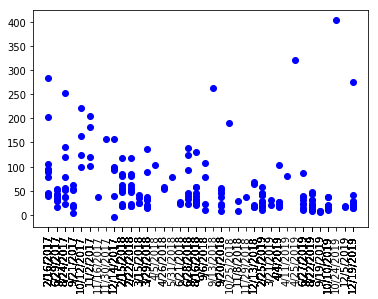

In [122]:
plt.plot(black_dates, black, 'bo')
plt.xticks(black_dates, rotation='vertical')

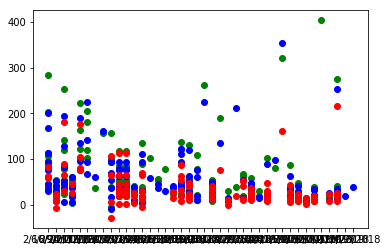

In [127]:
plt.plot(black_dates, black, 'go')
plt.plot(white_dates, white, 'bo')
plt.plot(red_dates, red, 'ro')

In [145]:
heatherGrey

[]

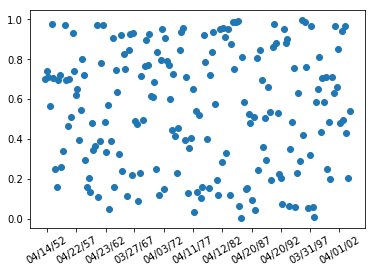

In [124]:
import matplotlib.pyplot as plt
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
import numpy as np
import datetime

# Fixing random state for reproducibility
np.random.seed(19680801)


# tick every 5th easter
rule = rrulewrapper(YEARLY, byeaster=1, interval=5)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%y')
date1 = datetime.date(1952, 1, 1)
date2 = datetime.date(2004, 4, 12)
delta = datetime.timedelta(days=100)

dates = drange(date1, date2, delta)
s = np.random.rand(len(dates))  # make up some random y values


fig, ax = plt.subplots()
plt.plot_date(dates, s)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)

plt.show()

In [148]:
import csv
with open('supreme_data_resell.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Name', 
                     'Date',
                     'Average',
                     'Retail',
                     'Search', 
                     'White sold', 'White price', 
                     'Black sold', 'Black price', 
                     'Red sold', 'Red price',
                     'Navy sold', 'Navy price',
                     'Grey sold', 'Grey price'])
    for entry in complete_data:
        whiteSold = None
        whitePrice = None
        blackSold = None
        blackPrice = None
        redSold = None
        redPrice = None
        navySold = None
        navyPrice = None
        greySold = None 
        greyPrice = None
        
        for color in entry['colors']:
            if color['color'] == 'white':
                whiteSold = color['deadstockSold']
                whitePrice = color['price']
            if color['color'] == 'black':
                blackSold = color['deadstockSold']
                blackPrice = color['price']
            if color['color'] == 'red':
                redSold = color['deadstockSold']
                redPrice = color['price']
            if color['color'] == 'navy':
                navySold = color['deadstockSold']
                navyPrice = color['price']
            if color['color'] == 'heather-grey':
                greySold = color['deadstockSold']
                greyPrice = color['price']
        writer.writerow([entry['name'], entry['date'], entry['average'], entry['retail'], entry['search'],
                         whiteSold, whitePrice, 
                         blackSold, blackPrice, 
                         redSold, redPrice,
                         navySold, navyPrice,
                         greySold, greyPrice])

In [149]:
whiteY = []
blackY = []
navyY = []
redY = []
greyY = []

for entry in complete_data:
    whiteSold = None
    whitePrice = None
    blackSold = None
    blackPrice = None
    redSold = None
    redPrice = None
    navySold = None
    navyPrice = None
    greySold = None 
    greyPrice = None

    for color in entry['colors']:
        if color['color'] == 'white':
            whiteSold = color['deadstockSold']
            whitePrice = color['price']
        if color['color'] == 'black':
            blackSold = color['deadstockSold']
            blackPrice = color['price']
        if color['color'] == 'red':
            redSold = color['deadstockSold']
            redPrice = color['price']
        if color['color'] == 'navy':
            navySold = color['deadstockSold']
            navyPrice = color['price']
        if color['color'] == 'heather-grey':
            greySold = color['deadstockSold']
            greyPrice = color['price']
    
    whiteY.append(whitePrice)
    blackY.append(blackPrice)
    navyY.append(navyPrice)
    redY.append(redPrice)
    greyY.append(greyPrice)

(array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175., 200.]),
 <a list of 0 Text xticklabel objects>)

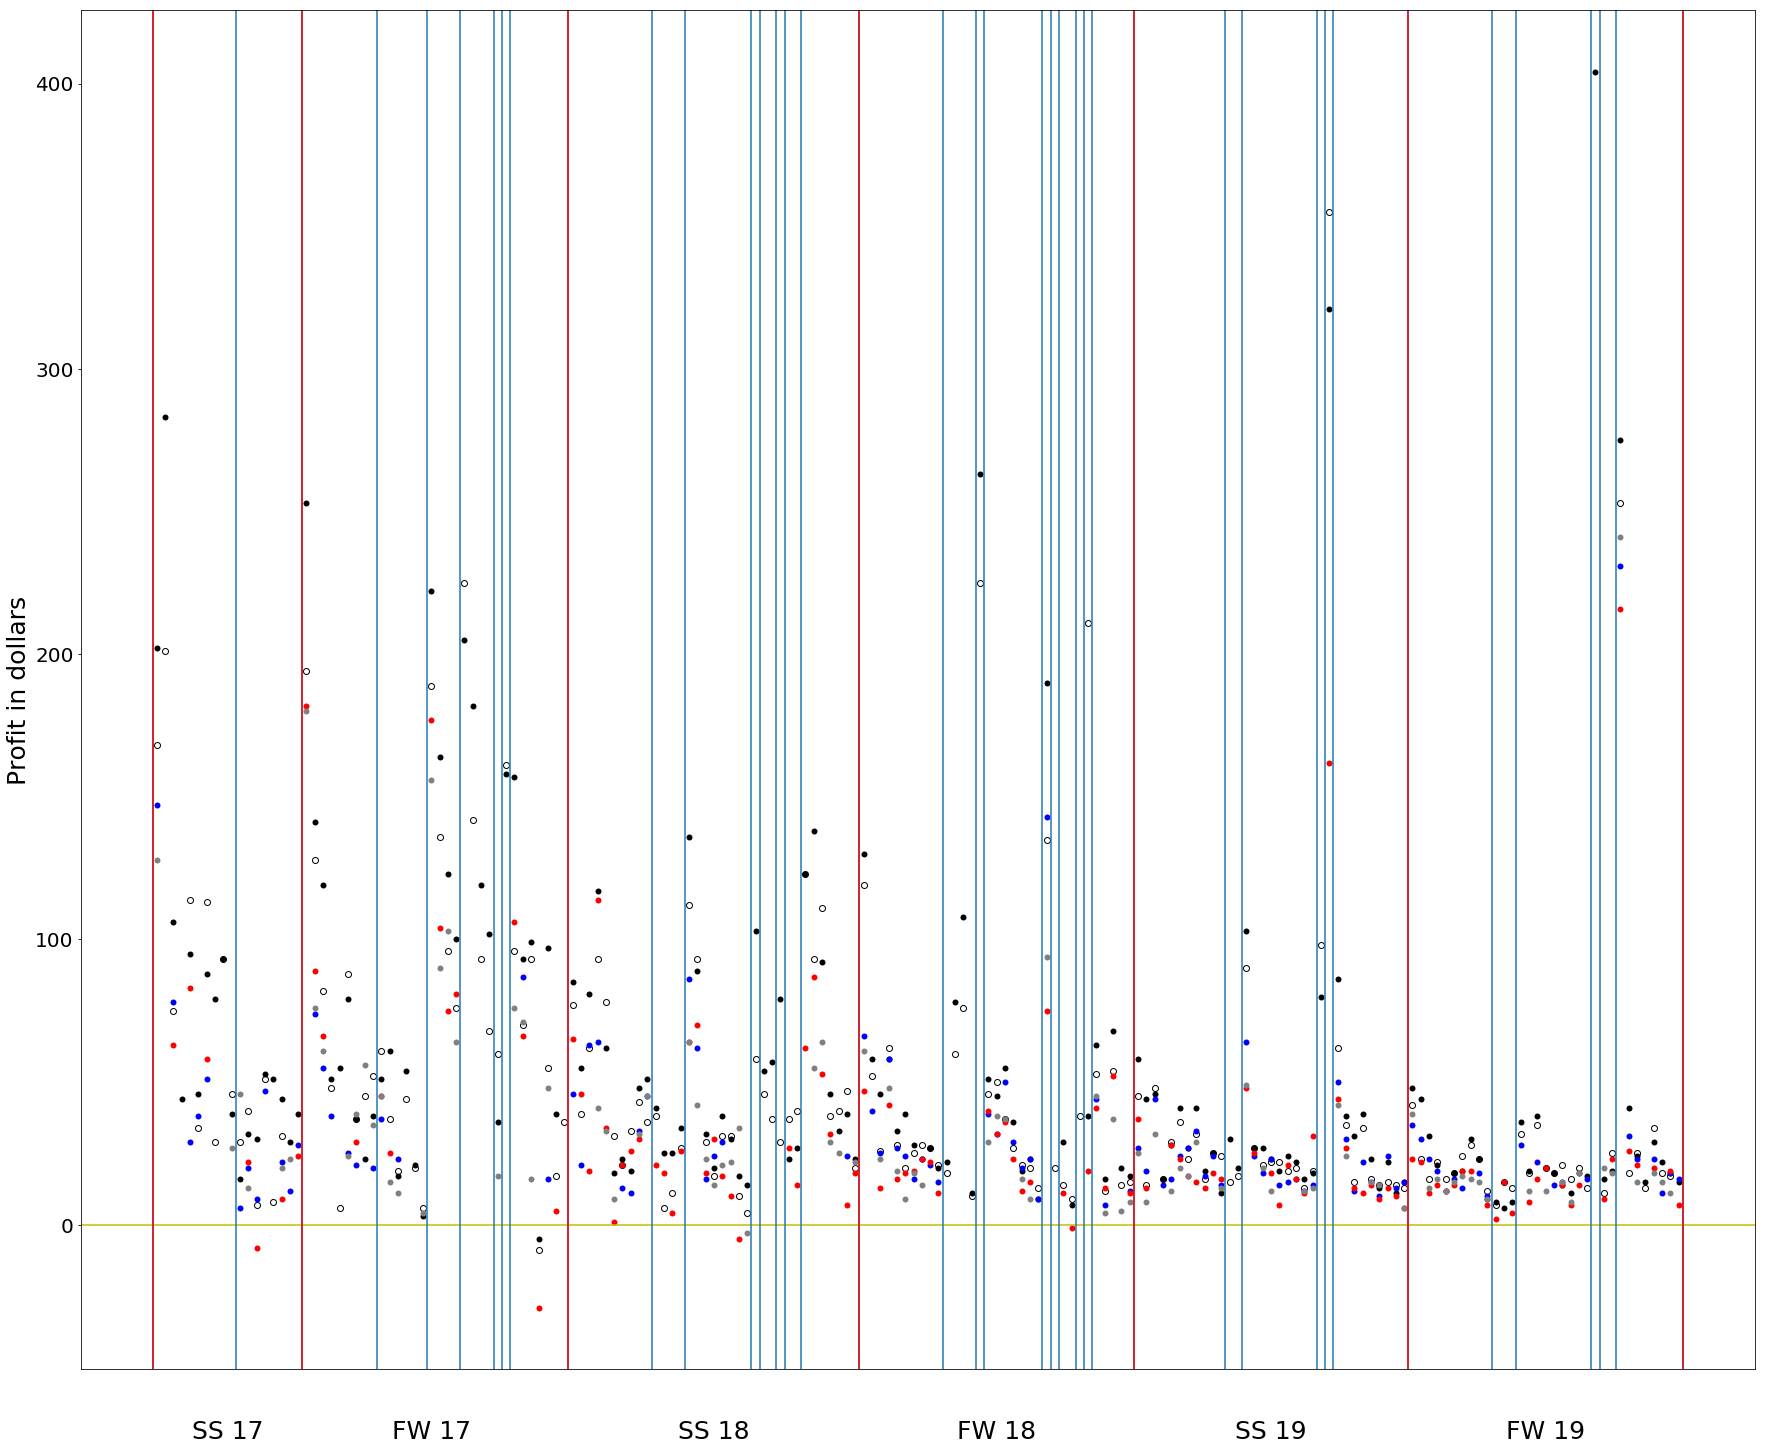

In [16]:
plt.figure(figsize=(30,25)) 
plt.plot([int(x[1]) if x[1] != '' else None for x in whiteData], linestyle='none', marker='o', markerfacecolor='white', markeredgecolor='black')
plt.plot([int(x[1]) if x[1] != '' else None for x in blackData], linestyle='none', marker='o', markerfacecolor='black', markeredgecolor='none')
plt.plot([int(x[1]) if x[1] != '' else None for x in navyData], linestyle='none', marker='o', markerfacecolor='blue', markeredgecolor='none')
plt.plot([int(x[1]) if x[1] != '' else None for x in redData], linestyle='none', marker='o', markerfacecolor='red', markeredgecolor='none')
plt.plot([int(x[1]) if x[1] != '' else None for x in greyData], linestyle='none', marker='o', markerfacecolor='grey', markeredgecolor='none')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.yticks(fontsize=20)
plt.ylabel("Profit in dollars", fontsize = 25)

plt.axhline(y=0, color='y')

for x_pos in [x - 0.5 for x in intervals] + [count - 0.5]:
    plt.axvline(x=x_pos)
    
for x_pos in [-0.5,17.5,49.5,84.5,117.5,150.5,183.5]:
    plt.axvline(x=x_pos, color='r')

plt.text(8.5,-75,'SS 17',horizontalalignment='center',fontsize=25)
plt.text(33,-75,'FW 17',horizontalalignment='center',fontsize=25)
plt.text(67,-75,'SS 18',horizontalalignment='center',fontsize=25)
plt.text(101,-75,'FW 18',horizontalalignment='center',fontsize=25)
plt.text(134,-75,'SS 19',horizontalalignment='center',fontsize=25)
plt.text(167,-75,'FW 19',horizontalalignment='center',fontsize=25)

plt.xticks()

In [2]:
import csv
whiteData = []
blackData = []
redData = []
navyData = []
greyData = []

count = 0
intervals = [0]
with open('supreme_data_resell.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    currentWeek = '2/16/2017'
    for row in reader:
        whiteData.append([row['White sold'], row['White price']])
        blackData.append([row['Black sold'], row['Black price']])
        redData.append([row['Red sold'], row['Red price']])
        navyData.append([row['Navy sold'], row['Navy price']])
        greyData.append([row['Grey sold'], row['Grey price']])
        
        if row['Date'] != currentWeek:
            currentWeek = row['Date']
            intervals.append(count)
        count += 1

In [178]:
whiteData

[['19', '168'],
 ['2', '201'],
 ['6', '75'],
 ['', ''],
 ['4', '114'],
 ['1', '34'],
 ['3', '113'],
 ['2', '29'],
 ['3', '93'],
 ['7', '46'],
 ['4', '29'],
 ['6', '40'],
 ['2', '7'],
 ['1', '51'],
 ['4', '8'],
 ['4', '31'],
 ['0', ''],
 ['0', ''],
 ['119', '194'],
 ['8', '128'],
 ['22', '82'],
 ['4', '48'],
 ['1', '6'],
 ['2', '88'],
 ['3', '37'],
 ['2', '45'],
 ['11', '52'],
 ['4', '61'],
 ['7', '37'],
 ['3', '19'],
 ['24', '44'],
 ['11', '20'],
 ['1', '6'],
 ['44', '189'],
 ['46', '136'],
 ['48', '96'],
 ['34', '76'],
 ['10', '225'],
 ['28', '142'],
 ['10', '93'],
 ['11', '68'],
 ['3', '60'],
 ['53', '161'],
 ['40', '96'],
 ['11', '70'],
 ['26', '93'],
 ['1', '-9'],
 ['12', '55'],
 ['8', '17'],
 ['49', '36'],
 ['17', '77'],
 ['3', '39'],
 ['23', '62'],
 ['15', '93'],
 ['7', '78'],
 ['31', '31'],
 ['16', '21'],
 ['23', '33'],
 ['15', '43'],
 ['7', '36'],
 ['50', '38'],
 ['39', '6'],
 ['51', '11'],
 ['98', '27'],
 ['49', '112'],
 ['50', '93'],
 ['15', '29'],
 ['13', '17'],
 ['13', '31'

In [182]:
[int(x[1]) if x[1] != '' else None for x in whiteData]

[168,
 201,
 75,
 None,
 114,
 34,
 113,
 29,
 93,
 46,
 29,
 40,
 7,
 51,
 8,
 31,
 None,
 None,
 194,
 128,
 82,
 48,
 6,
 88,
 37,
 45,
 52,
 61,
 37,
 19,
 44,
 20,
 6,
 189,
 136,
 96,
 76,
 225,
 142,
 93,
 68,
 60,
 161,
 96,
 70,
 93,
 -9,
 55,
 17,
 36,
 77,
 39,
 62,
 93,
 78,
 31,
 21,
 33,
 43,
 36,
 38,
 6,
 11,
 27,
 112,
 93,
 29,
 17,
 31,
 31,
 10,
 4,
 58,
 46,
 37,
 29,
 37,
 40,
 123,
 93,
 111,
 38,
 40,
 47,
 20,
 119,
 52,
 26,
 62,
 28,
 20,
 25,
 28,
 27,
 21,
 18,
 60,
 76,
 10,
 225,
 46,
 50,
 37,
 27,
 21,
 20,
 13,
 135,
 20,
 14,
 9,
 38,
 211,
 53,
 12,
 54,
 14,
 15,
 45,
 14,
 48,
 16,
 29,
 36,
 23,
 32,
 16,
 25,
 24,
 15,
 17,
 90,
 27,
 21,
 22,
 22,
 19,
 20,
 13,
 19,
 98,
 355,
 62,
 35,
 15,
 34,
 16,
 14,
 15,
 14,
 13,
 42,
 23,
 16,
 22,
 16,
 18,
 24,
 28,
 23,
 12,
 7,
 15,
 13,
 32,
 18,
 35,
 20,
 18,
 21,
 16,
 20,
 13,
 None,
 11,
 25,
 253,
 18,
 25,
 13,
 34,
 18,
 17,
 None]

In [197]:
count

184

(array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175., 200.]),
 <a list of 0 Text xticklabel objects>)

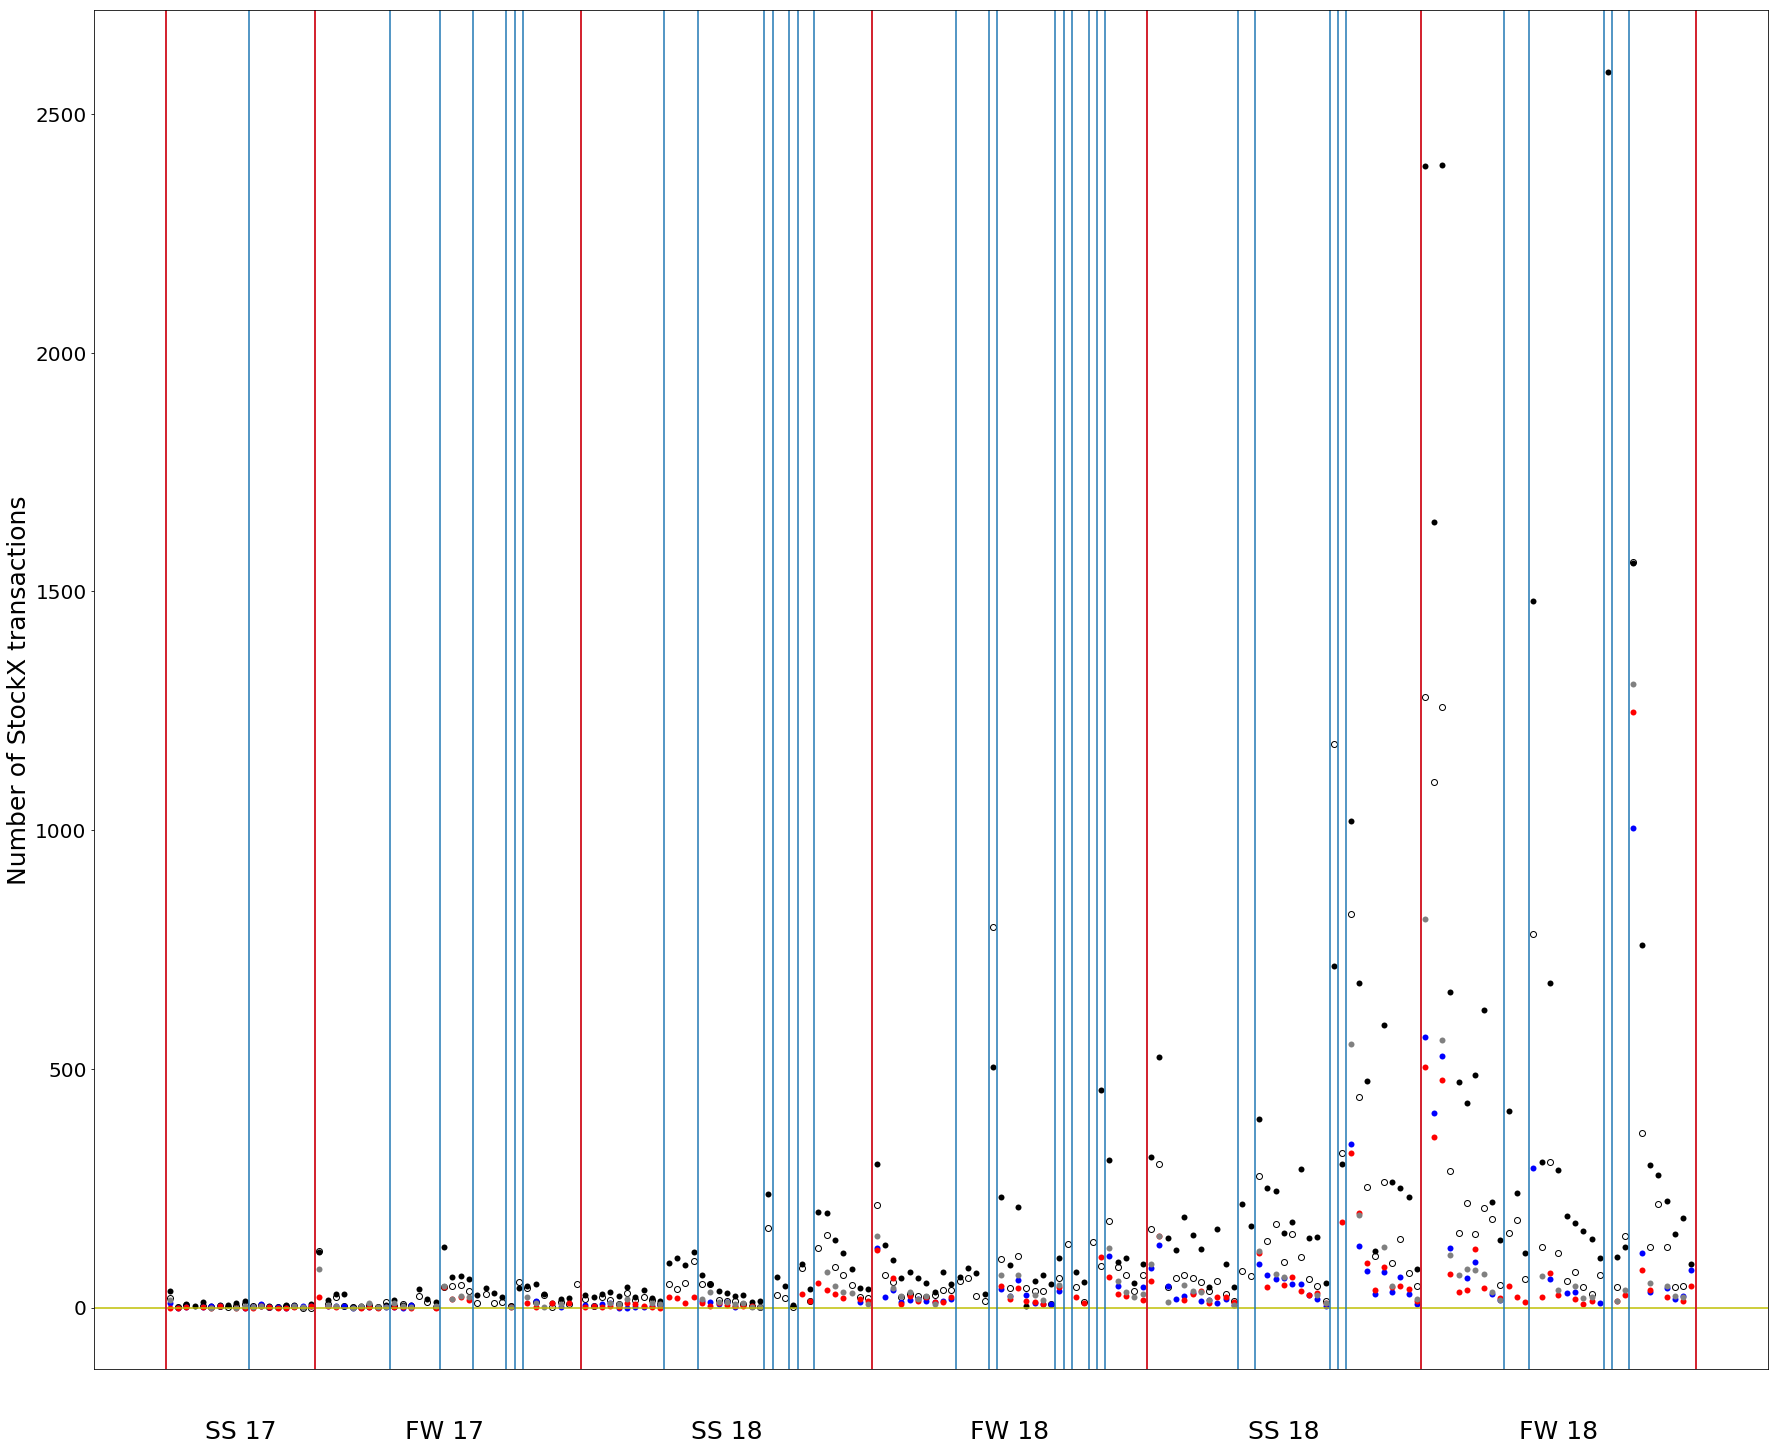

In [14]:
plt.figure(figsize=(30,25)) 
plt.plot([int(x[0]) if x[0] != '' else None for x in whiteData], linestyle='none', marker='o', markerfacecolor='white', markeredgecolor='black')
plt.plot([int(x[0]) if x[0] != '' else None for x in blackData], linestyle='none', marker='o', markerfacecolor='black', markeredgecolor='none')
plt.plot([int(x[0]) if x[0] != '' else None for x in navyData], linestyle='none', marker='o', markerfacecolor='blue', markeredgecolor='none')
plt.plot([int(x[0]) if x[0] != '' else None for x in redData], linestyle='none', marker='o', markerfacecolor='red', markeredgecolor='none')
plt.plot([int(x[0]) if x[0] != '' else None for x in greyData], linestyle='none', marker='o', markerfacecolor='grey', markeredgecolor='none')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.yticks(fontsize=20)
plt.ylabel("Number of StockX transactions", fontsize = 25)

plt.axhline(y=0, color='y')

for x_pos in [x - 0.5 for x in intervals] + [count - 0.5]:
    plt.axvline(x=x_pos)
    
for x_pos in [-0.5,17.5,49.5,84.5,117.5,150.5,183.5]:
    plt.axvline(x=x_pos, color='r')

plt.text(8.5,-275,'SS 17',horizontalalignment='center',fontsize=25)
plt.text(33,-275,'FW 17',horizontalalignment='center',fontsize=25)
plt.text(67,-275,'SS 18',horizontalalignment='center',fontsize=25)
plt.text(101,-275,'FW 18',horizontalalignment='center',fontsize=25)
plt.text(134,-275,'SS 18',horizontalalignment='center',fontsize=25)
plt.text(167,-275,'FW 18',horizontalalignment='center',fontsize=25)

plt.xticks()